In [1]:
from keras import layers
from keras.layers import Lambda, Input, Dense
from keras.models import Model, model_from_json
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

import sys
sys.path.insert(0, '../code')
import cheauder_utils
from vae_smiles import CustomVariationalLayer

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 120, 36)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 112, 9)       2925        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 9)       36          conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 104, 9)       738         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [2]:
encoder = cheauder_utils.load_coder_json("../code/model/1encoder_196_120x36.json",
                                         "../code/weights/1encoder_weights.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})


decoder = cheauder_utils.load_coder_json("../code/model/1decoder_196_120x36.json",
                                         "../code/weights/1decoder_weights.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})

In [5]:
X, y, charset, chars = cheauder_utils.load_data('../data/250k_rndm_zinc_drugs_clean_3.csv', col_smiles=0, col_target=1, delimiter=',', max_len=120)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
z_mean, _, _ = encoder.predict(x_test, batch_size=500)

In [3]:
x_test_pred_cont = decoder.predict(z_mean, batch_size=500)
x_test_pred = np.array([(x.argmax(axis=1)[:, None] == np.arange(x.shape[1])).astype(int) for x in x_test_pred_cont])
cheauder_utils.correctly_decoded(x_test_pred, x_test, chars)

Percentage correctly predicted: 25.33
Mean error: 2.52


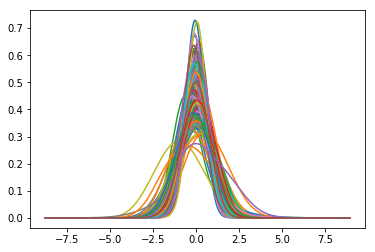

In [6]:
cheauder_utils.plot_kde(z_mean)

In [7]:
Xvae, y, charset, chars = cheauder_utils.load_data('../data/BBBP.csv',
                                                charset_filename='../code/model/charset_ZINC.json',
                                                col_smiles=3, col_target=2, delimiter=',',
                                                max_len=120)

Xfinger, y, valid = cheauder_utils.load_fingerprints('../data/BBBP.csv', col_smiles=3, col_target=2, delimiter=',')
Xvae = Xvae[valid]
Xvae, _, _ = encoder.predict(Xvae)

In [6]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
svc = SVC(kernel='linear')
rfc = RandomForestClassifier(n_estimators=500, random_state=0)
kn = KNeighborsClassifier(n_neighbors=3)
classifiers = {'SVC': svc, 'RFC': rfc, 'KN': kn}
X_train, X_test, y_train, y_test = train_test_split(Xvae, y, test_size=0.2, random_state=322)
Xs = {'VAE': Xvae, 'Fingerprint': Xfinger}

cheauder_utils.classification_test(Xs, y, classifiers, n_splits=10)

VAE | SVC : 0.702415681711764
VAE | RFC : 0.7084573690707606
VAE | KN : 0.6818508165784583
Fingerprint | SVC : 0.7136666926798814
Fingerprint | RFC : 0.6828903401109582
Fingerprint | KN : 0.6506154490117343


OrderedDict([(('VAE', 'SVC'), 0.702415681711764),
             (('VAE', 'RFC'), 0.7084573690707606),
             (('VAE', 'KN'), 0.6818508165784583),
             (('Fingerprint', 'SVC'), 0.7136666926798814),
             (('Fingerprint', 'RFC'), 0.6828903401109582),
             (('Fingerprint', 'KN'), 0.6506154490117343)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1927 samples in 0.006s...
[t-SNE] Computed neighbors for 1927 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1927
[t-SNE] Computed conditional probabilities for sample 1927 / 1927
[t-SNE] Mean sigma: 2.615725
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.503014
[t-SNE] KL divergence after 500 iterations: 1.058738


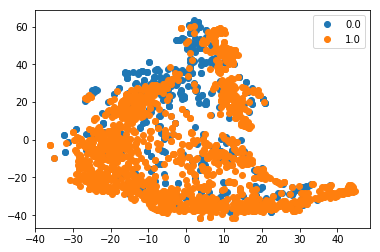

In [8]:
pca = PCA(n_components=20)
pca_res = pca.fit_transform(Xvae)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
res = tsne.fit_transform(pca_res)

fig, ax = plt.subplots()
for yi in np.unique(y):
    plt.plot(np.array(res[:,0])[y==yi], np.array(res[:,1])[y==yi], 'o', label=str(yi))
plt.legend()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1927 samples in 0.002s...
[t-SNE] Computed neighbors for 1927 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1927
[t-SNE] Computed conditional probabilities for sample 1927 / 1927
[t-SNE] Mean sigma: 0.956943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.536217
[t-SNE] KL divergence after 500 iterations: 0.900908


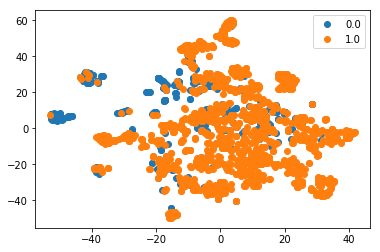

In [9]:
pca = PCA(n_components=20)
pca_res = pca.fit_transform(Xfinger)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
res = tsne.fit_transform(pca_res)

fig, ax = plt.subplots()
for yi in np.unique(y):
    plt.plot(np.array(res[:,0])[y==yi], np.array(res[:,1])[y==yi], 'o', label=str(yi))
plt.legend()
plt.show()